# The predition model data flow between Teradata and Aster R

## Overview
## 1. Load input data from Teradata to Aster
## 2. Create a TA data frame
## 3. Build a model and make predictions in Aster R 
## 4. Evaluate the model (lift chart, ROC curve, confusion matrix)
## 5. Feed model scores back to Teradata
## ==========================================================

### 1.a Load the libraries & connect to databases

In [1]:
library(TeradataAsterR)
library(kpnr)
library(RJDBC)
library(RODBC)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

Loading required package: RODBC
Loading required package: DBI
Loading required package: rJava
Warning message:
: package 'ggplot2' was built under R version 3.2.4

In [18]:
conn_aster <- connect_aster()
conn_teradata <- connect_teradata()
config <- getOption("kpn")
ta.connect(config$aster$odbc_dsn)

Warning message:
In dir.create(paste0(root, "/.R.ta.session")): 'C:\Users\i\.R.ta.session' already exists

RODBC Connection 2
Details:
  case=nochange
  DSN=AsterKPN

### 1.b Transfer data from Teradata to Aster

In [3]:
one_row <- query_teradata(conn_teradata,"SELECT * FROM  P0_AN0_MARKETING.mvc_modelfactory_zm_mobile_klant_final SAMPLE 1")
#remove column featuring diacrites 
drops <- c("branche")
one_row <- one_row[,!(names(one_row) %in% drops)]

select_query <- sprintf(
      "select %s FROM P0_AN0_MARKETING.mvc_modelfactory_zm_mobile_klant_final",
       paste(sapply(names(one_row),substrRight),collapse = ","))

## helper necessary for table transferring
update_aster(conn_aster, "DROP TABLE if exists public.<teradata_username>_mrs_driver")
update_aster(conn_aster, "CREATE TABLE public.<teradata_username>_mrs_driver (c1 INT) DISTRIBUTE BY HASH (c1)") 

load_query <- sprintf("CREATE TABLE public.<teradata_username>_modelfactory_zm_mobklnt DISTRIBUTE BY HASH(\"klt_id\")
                     as SELECT * FROM LOAD_FROM_TERADATA( ON public.<teradata_username>_mrs_driver TDPID('<teradata_ip>')
                     USERNAME('<teradata_username>') PASSWORD('<teradata_password>')
                     NUM_INSTANCES('8') QUERY('%s;') )", select_query)

resolved_query <- stringr::str_replace_all(load_query, c("<teradata_username>" = config$teradata$username)) 

update_aster(conn_aster, "DROP TABLE if exists public.<teradata_username>_modelfactory_zm_mobklnt") 
update_aster(conn_aster, resolved_query) 

### 2.a Create a TA virtual data frame

In [4]:
sourceDefinition <- "select a.*, case when churn_ind=1 then 'Y' else 'N' end as churn_ind_factor
                     from public.<teradata_username>_modelfactory_zm_mobklnt a where yearmonth in
                     (201506,201507,201508)"
resolvedSourceDefinition <- stringr::str_replace_all(sourceDefinition, c("<teradata_username>" = config$teradata$username))
tadf <- ta.data.frame(sourceDefinition = resolvedSourceDefinition, sourceType = 'query')

### 2.b Pull the Data frame locally in order to compare the results

In [5]:
start <- Sys.time()
tadf_local <- ta.pull(tadf)
end <- Sys.time()
cat(paste("Pulling of tadf to local node accomplished in:", end - start, "min."))

Pulling of tadf to local node accomplished in: 1.61744706630707 min.

### 3.a Create model & make predictions in Aster R

#### 3.a.1 Random Forest from randomForest package on Aster cluster (one node)

In [6]:
rf_randomforest<-function(dataset) {
      
      ## load all packages and dependencies:
      require(dplyr)
      require(rpart)
      require(randomForest)
      attach(dataset)

      ## correcting the dataset:
      dataset$max_n_days_outcon_bm_voice <- as.numeric(dataset$max_n_days_outcon_bm_voice)
      dataset$churn_ind <- as.factor(dataset$churn_ind)

      ## training and test samples:
      training_sample <- 0.7
      idx <- 1:nrow(dataset)
      aantal_in_training_set <- round(training_sample * nrow(dataset))
      tr_idx <- sample(idx,aantal_in_training_set)

      train_set <- dataset[tr_idx,]
      test_set <- dataset[-tr_idx,]

      levels(test_set$churn_ind) <- levels(train_set$churn_ind)

      ## remove columns which you do not want to include in the model:
      remove_column<-c("yearmonth", "klt_id", "first_active_dt_klant", "churn_perc", 
                       "churn_ind_old", "branche", "rechtsvorm", "churn_ind", "churn_ind_factor")
    
      formula <- tolower(paste("churn_ind_factor ~ ", 
                               paste(names(train_set[,!names(train_set) %in% remove_column]), collapse="+"),
                               sep = "")
                        )

      forest <-randomForest(formula = as.formula(formula),
                            data = train_set,
                            ntree = 10,
                            keep.forest = TRUE
                           )

      prediction_values <- as.data.frame(predict(forest, newdata = test_set, "prob"))
      output <- data.frame("prediction" = prediction_values$Y, "churn_ind" = test_set$churn_ind, "klt_id" = test_set$klt_id)
      return(output)
}     

### 3.b Run Random forest Model (either on Aster node or locally)

#### 3.b.1 Aster, from randomForest

In [7]:
start <- Sys.time()
prediction_values_representative_table <- ta.aggregateApply(tadf, 
                                                            rf_randomforest,
                                                            FUN.memLimitMB = 0, 
                                                            COMBINER.FUN.memLimitMB = 0
                                                           )
end <- Sys.time()
cat(paste("Executing model in Aster accomplished in:", end - start, "min."))

ERROR: Error in taQuery(queryStr, stringsAsFactors = FALSE, stopOnError = TRUE): HY000 34 [AsterData][nCluster] (34) ERROR: SQL-MR function STREAM failed: Stream process exited with non-zero exit value (1). Last few lines of output were:
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: rpart
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/


Executing model in Aster accomplished in: 16.3390748500824 min.

#### 3.b.3 Local, from randomForest

In [8]:
start <- Sys.time()
prediction_values_representative_table <- rf_randomforest(tadf_local)
end <- Sys.time()
cat(paste("Executing model locally accomplished in:", end - start, "min."))

Loading required package: rpart
Loading required package: randomForest
Warning message:
: package 'randomForest' was built under R version 3.2.4randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine



Executing model locally accomplished in: 24.4536051750183 min.

### 4.a Define the model evaluation functions:

In [9]:
## lift chart
get_lift_line <- function(scores, model_name, labels) {
    df <- data.frame(labels = labels, scores = scores, dummy = 1, model = model_name)
    num_customers <- nrow(df)
    num_target <- sum(df$labels)
    df %>% 
        arrange(desc(scores)) %>% 
            mutate(population = cumsum(dummy) / num_customers,
            target = cumsum(labels) / num_target) %>% 
                select(population, target, model)
}

## roc curve
get_roc_line <- function(scores, model_name, labels) {
    df <- data.frame(labels = labels, scores = scores, dummy = 1, model = model_name)
    num_customers <- nrow(df)
    num_target <- sum(df$labels)
    df %>% 
        arrange(desc(scores)) %>%
            mutate(population = cumsum(dummy) / num_customers,
            sensitivity = cumsum(labels) / num_target,
            specificity = (num_customers - num_target - cumsum(dummy) + cumsum(labels)) / (num_customers-num_target)) %>%
                select(population, sensitivity, specificity, model) 
}

## confusion matrix
get_conf_matrix <- function(scores,labels,cut_off) {
    df <- data.frame(labels = labels, scores = scores)
    roc1<-get_roc_line(df$scores," ",df$labels)
    roc1<-subset(roc1,population>=cut_off)
    num_pos <- sum(df$labels)
    num_neg <- nrow(df)-sum(df$labels)
    p<-min(roc1$population-cut_off)+cut_off
    roc<-subset(roc1,population==p)
    
    actual_positives<-c(
                        predicted_positives=floor(num_pos*roc$sensitivity), 
                        predicted_negatives=floor(num_pos*(1-roc$sensitivity))
    )
    
    actual_negatives<-c(
                        floor(num_neg*(1 - roc$specificity)),
                        floor(num_neg*roc$specificity)
    )
    
    rbind(actual_positives, actual_negatives)
}

### 4.b Evaluate Model

In [10]:
a_p <- data.frame("prediction" = prediction_values_representative_table$prediction,
                  "churn_ind" = prediction_values_representative_table$churn_ind)
    a_p <- a_p[complete.cases(a_p),] #lege records niet meenemen
    a_p <- a_p[!grepl("NA",as.character(a_p$churn_ind)),]
    a_p$churn_ind <- as.numeric(as.character(a_p$churn_ind))

In [11]:
aster_line <- get_lift_line(a_p$prediction, "Aster", a_p$churn_ind) #liftchart tabel
aster_roc <- get_roc_line(a_p$prediction, "Aster", a_p$churn_ind) #ROC tabel
aster_roc <- aster_roc[,-1]

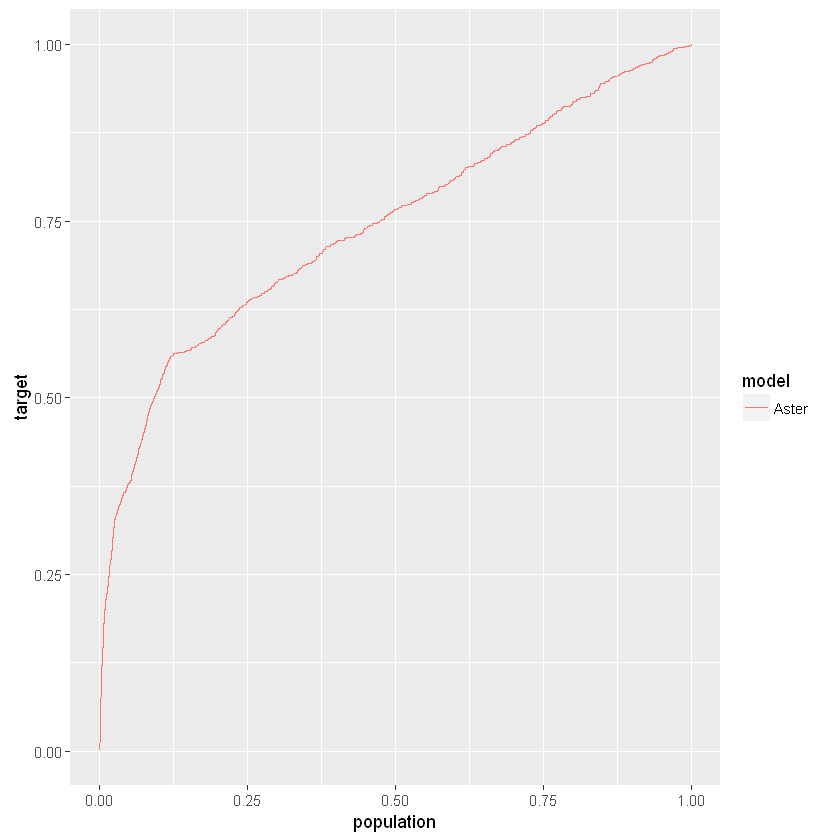

In [12]:
## Liftchart graph:
ggplot(aster_line) + geom_line(aes(x = population, y = target, group = model, color = model))

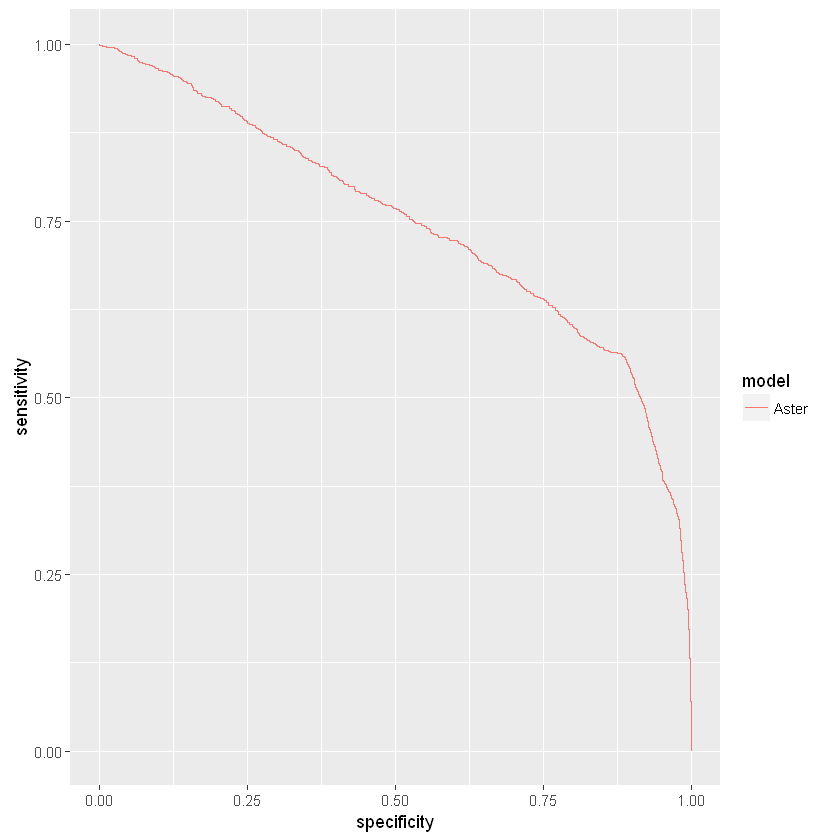

In [13]:
## ROC curve graph:
ggplot(aster_roc) + geom_line(aes(x = specificity, y = sensitivity, group = model, color = model))

In [14]:
## confusion matrix: cut-off is top 30%
get_conf_matrix(a_p$prediction, a_p$churn_ind, 0.3)

,predicted_positives,predicted_negatives
actual_positives,738,373
actual_negatives,21199,50812


### 5.a Transfer the model data from Aster back to Teradata

In [15]:
update_aster(conn_aster, "DROP TABLE if exists p0_an1_operations.<teradata_username>_forest_output")
ta.create(prediction_values_representative_table, 
          table=stringr::str_replace_all("<teradata_username>_forest_output", c("<teradata_username>" = config$teradata$username)),
          schemaName = "p0_an1_operations",
          tableType = "fact",
          partitionKey = "klt_id",
          row.names = TRUE
)

update_teradata(conn_teradata,"DROP TABLE cim_work_tst.td_customer_test_zm")
update_teradata(conn_teradata,
                 "create table cim_work_tst.td_customer_test_zm(
                 row_names int,
                 prediction float,
                 churn_ind int,
                 klt_id int)"
)

load_query1 <- (
                "SELECT * FROM load_to_teradata(
                ON (SELECT * FROM p0_an1_operations.<teradata_username>_forest_output)
                TDPID('<teradata_ip>')
                USERNAME('<teradata_username>')
                PASSWORD('<teradata_password>')
                TARGET_TABLE('cim_work_tst.td_customer_test_zm')
                START_INSTANCE('6')
                NUM_INSTANCES('6'))"
)

query_aster(conn_aster,load_query1)

,loaded_row_count,error_row_count
1,0,0
2,0,0
3,18242,0
4,0,0
5,0,0
6,0,0


### 5.b Clean-up Aster

In [21]:
update_aster(conn_aster, "DROP TABLE if exists public.<teradata_username>_modelfactory_zm_mobklnt")
update_aster(conn_aster, "DROP TABLE if exists public.<teradata_username>_mrs_driver")
update_aster(conn_aster, "DROP TABLE if exists p0_an1_operations.<teradata_username>_forest_output")

In [22]:
nrow(prediction_values_representative_table)

[1] 73122